# Getting the data

- This dataset comes from [Kaggle](https://www.kaggle.com/martj42/international-football-results-from-1872-to-2017/kernels)

In [56]:
%matplotlib inline
import pandas as pd
import numpy as np
from plotnine import *
from mizani.breaks import date_breaks

# Supress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
df = pd.read_csv("./data/results.csv")

In [6]:
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


# Visualizing average score per year for Brazil

- We'll break down the dataset into Friendly, World Cup, or Other matches

In [7]:
def get_game_type(tournaments):
    def _get_game_type(tournament):
        if not tournament:
            return np.nan
        elif tournament == "FIFA World Cup":
            return "World Cup"
        elif tournament == "Friendly":
            return "Friendly"
        else:
            return "Other"
    if isinstance(tournaments, pd.Series):
        return tournaments.apply(_get_game_type)
    else:
        _get_game_type(tournaments)

In [33]:
df_bra_avg0 = (df.query("home_team == 'Brazil' or \
                        away_team == 'Brazil'")
                  .assign(brazil_score = lambda x:
                              np.where(x['home_team'] == 'Brazil',
                                       x['home_score'],
                                       x['away_score']),
                          year = lambda x: x['date'].dt.year,
                          game_type = lambda x: get_game_type(x['tournament']))
                  .groupby(['year', 'game_type'])
                  .agg({'brazil_score': 'mean'})
                  .reset_index())

df_game_type = (df_bra_avg0.groupby('game_type')
                           .agg({'brazil_score': 'mean'})
                           .reset_index()
                           .rename(columns={'brazil_score': 'game_type_avg'}))

In [41]:
df_bra_avg = (pd.merge(df_bra_avg0,
                       df_game_type,
                       how='left',
                       on='game_type')
                .assign(year_dt = lambda x: pd.to_datetime({'year': x['year'],
                                                           'month': 1,
                                                           'day': 1})))

In [42]:
df_bra_avg.head()

,year,game_type,brazil_score,game_type_avg,year_dt
0,1914,Friendly,0.0,2.253909,1914-01-01
1,1914,Other,1.0,2.144016,1914-01-01
2,1916,Friendly,1.0,2.253909,1916-01-01
3,1916,Other,1.0,2.144016,1916-01-01
4,1917,Friendly,1.0,2.253909,1917-01-01


In [52]:
%pdb off 
from datetime import date
def custom_year_format(breaks):
    res = []
    century = [0]
    for x in breaks:
        if century[-1] != str(x.year)[:2]:
            century.append(str(x.year)[:2])
            fmt = "%Y"
        else:
            fmt = "%y"
        
        res.append(date.strftime(x, fmt))
        
    return res

Automatic pdb calling has been turned OFF


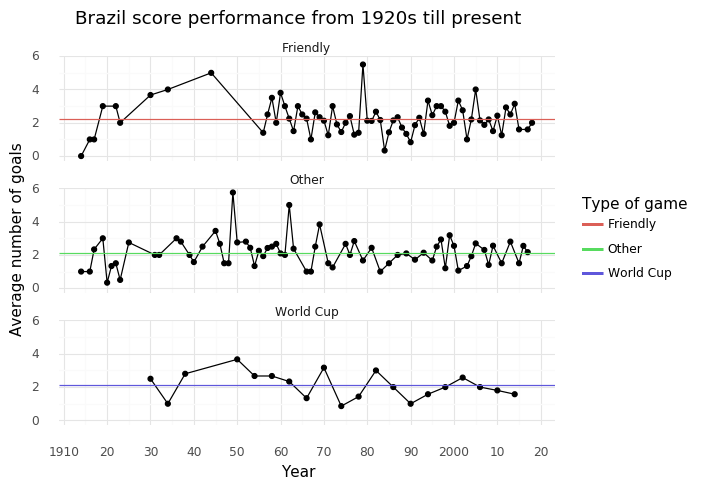

<ggplot: (8774019470726)>

In [60]:
(ggplot(df_bra_avg, aes(y='brazil_score', x='year_dt')) +
 geom_point() +
 geom_line() +
 geom_hline(aes(yintercept='game_type_avg',
               color='factor(game_type)')) +
 scale_x_datetime(labels=custom_year_format,
                 breaks=date_breaks('10 years')) +
 facet_wrap("~game_type", nrow=3) +
 labs(y="Average number of goals",
      x="Year",
      title="Brazil score performance from 1920s till present",
      color='Type of game') +
 theme_minimal()
)
    